# Peaking emissions

* A key step on the way to reducing emissions is for them to peak, at both a national and global level
* This notebook reads in emissions data (either national totals or subsectors) and assesses how many countries have peaked emissions. In addition, it explores which countries have emissions that may have stabilised vs. those that are clearly still increasing.
* The specific criteria for 'peaking' emissions can be set by the user, and include
    * a date since which emissions must have peaked - this removes countries whose emissions peaked since 1990 but have since increased. 
    * a more recent end year *before* which emissions must have peaked. This excludes countries whose maxima in emissions was in the last few years but not long enough ago to be sure that they will not increase again. 
    * A period over which average emissions have steadily decreased by a given threshold, e.g. average 5-yearly decrease of 1.5% per year.
    
    

Observations: 
* the longer the averaging period for the calculation of a trend, the fewer peaked / stabilised countries. It's also less sensitive to recent trends though and therefore maybe more robust. 
* Question: What are the best parameters??
* are there some instances where a rolling average is better and some where an annual (or shorter) average is better?
* changing the start year between 1990 and 2000 may change which countries are considered 'stabilised'

In [1]:
# import modules

# system
import sys, os, re

# for analysis
import pandas as pd
import numpy as np

# for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils

#from shortcountrynames import to_name
from countrygroups import EUROPEAN_UNION, UNFCCC, LDC, SIDS, UMBRELLA

In [2]:
# User specs

"""
PLEASE ADJUST THE FOLLOWING PARAMETERS TO SUIT YOUR NEEDS! 
"""

# File containing data to be used:
data_file_name = 'PRIMAP-hist_v2.0_KyotoGHG-AR4-total-excl-LU.csv'
#data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'

# keep plots nice!
var_name_for_plots = 'greenhouse gas emissions (excl. LULUCF)'


# year since which peaking must have occurred:
peak_since = 1990

# number of years before end of data series BY which peak should have occurred:
nyears = 5

# number of years over which emissions trend should be averaged
n_trend_years = 5

# Emissions only evaluated as peaking if n-year trend is less than X%
# (negative sign needed for decreasing emissions ie. 
# if threshold is -2%  means a greater than 2% DECREASE in emissions.)
decrease_threshold = -1.5


# region to assess 
# (TODO - fix, currently crashes with non-UNFCCC groups because of missing categories)
region_of_interest = UNFCCC
#region_of_interest = EUROPEAN_UNION


In [3]:
# Read the data

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# Check the data format
if not utils.verify_data_format(data):
    print('WARNING: The data is not correctly formatted! Please check before continuing!')

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

# reduce to only the countries of interest (for easier plotting etc.)
data = data.loc[data['country'].isin(region_of_interest)]

# reorganise and clean the data
data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

# remove comment below to display the data
#data_years

In [4]:
# Year of peaking 

"""
Makes a histogram of the year in which emissions have peaked since the start year specified above (peak_since).
"""

reduced_data = utils.change_first_year(data_years, peak_since)

year_max = reduced_data.idxmax(axis=1)
year_max = pd.to_numeric(year_max)
year_max.name = 'peak year'

start_year = min(list(map(int, data_years.columns)))
end_year = max(list(map(int, data_years.columns)))

make_histogram_peaking(year_max, var_name_for_plots, '', peak_since, end_year, save_plot=True)
    

First year of data available is now 1990
Last year of data available is 2016


In [5]:
# Interrogate the data with different conditions (peak year, decreasing rate) to categorise countries  

# set up a dataframe to store analysis results
peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max
  

# Identify countries that have 'peaked' before the time period chosen by the user above (n years ago)
peaking_assessment['max_reached'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year - nyears)))

# Identify countries with decreasing emissions trends
recent_trends, recent_trends_rolling, unit = utils.calculate_trends(reduced_data, num_years_trend=n_trend_years)
peaking_assessment['trend'] = recent_trends_rolling[str(end_year)]

peaking_assessment['decreasing'] = peaking_assessment['trend'].apply(lambda x: (x < 0))
peaking_assessment['strongly_decreasing'] = peaking_assessment['trend'].apply(lambda x: (x < decrease_threshold))
peaking_assessment['stable'] = peaking_assessment['trend'].apply(lambda x: (decrease_threshold < x < 0.5))


# Use multi-criteria to define different regimes
# First, the clear cases...
peaking_assessment['peaked']     = peaking_assessment['max_reached'] & \
                                   peaking_assessment['strongly_decreasing']

peaking_assessment['stabilised'] = (peaking_assessment['max_reached'] & \
                                    peaking_assessment['stable']) | \
                                   ((peaking_assessment['max_reached']==False) & \
                                    (peaking_assessment['strongly_decreasing']))

peaking_assessment['not_peaked'] = (peaking_assessment['stabilised']==False) & \
                                   (peaking_assessment['peaked']==False)


# Get stats of shares
share_peaked     = peaking_assessment['peaked'].value_counts(normalize=True) 
share_stabilised = peaking_assessment['stabilised'].value_counts(normalize=True)
share_increasing = peaking_assessment['not_peaked'].value_counts(normalize=True)
check_total = share_peaked[True] + share_stabilised[True] + share_increasing[True]


# and print to screen...
print('')
print('Share of countries peaked is {:.1f}%'.format(share_peaked[True]*100))
print('Share of countries stabilised is {:.1f}%'.format(share_stabilised[True]*100))
print('Share of countries not peaked or stabilised is {:.1f}%'.format(share_increasing[True]*100))
print('Total is: {:.1f}%'.format(check_total*100))
print('')

# old categories..
#print('Share of countries possibly stabilised is {:.1f}%'.format(share_possible[True]*100))
#print('Share of countries remaining is {:.1f}%'.format(share_remaining[True]*100))


Averaging trend over 5 years.

Share of countries peaked is 10.3%
Share of countries stabilised is 15.9%
Share of countries not peaked or stabilised is 73.8%
Total is: 100.0%



In [6]:
# Make a plot to summarise how many countries fall into each group.

# count the number of countries in each category
number_peaked     = peaking_assessment['peaked'].value_counts(normalize=False) 
number_stabilised = peaking_assessment['stabilised'].value_counts(normalize=False)
number_increasing = peaking_assessment['not_peaked'].value_counts(normalize=False)
total_countries = number_peaked[True] + number_stabilised[True] + number_increasing[True]

# define new dataframe
summary_data = pd.DataFrame({'category': ['peaked', 'stabilised', 'not peaked'],
                             'count': [number_peaked[True],  number_stabilised[True], number_increasing[True]]})

# make the plot
peaking_barplot(summary_data, var_name_for_plots, str(end_year), save_plot=True)


In [7]:
# And make some plots to view and check the results. 


"""
These functions will plot facet grids of the emissions trends and absolute emissions
for all countries in each category. 

Note that this can take quite some time to run! 
"""


# 1. Peaking
# prep data for plotting 
peaked_country_trends = recent_trends_rolling[peaking_assessment['peaked']]
peaked_country_abs = data_years[peaking_assessment['peaked']] 

# make the plots
plot_facet_grid_countries(peaked_country_trends, 'year', '% change', 
                          main_title='Countries with peaked emissions', 
                          plot_name=('peaked-' + variable), save_plot=True)

plot_facet_grid_countries(peaked_country_abs, 'year', 'emissions', 
                          main_title='Absolute emissions for peaked countries', 
                          plot_name=('peaked-' + variable), save_plot=True)

    
# 2. Stabilised
stab_trends = recent_trends_rolling[peaking_assessment['stabilised']]
stab_abs    = data_years[peaking_assessment['stabilised']] 

plot_facet_grid_countries(stab_trends, 'year', '% change', 
                         main_title='Trends in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)
plot_facet_grid_countries(stab_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with stabilised emissions', 
                         plot_name=('stabilised-' + variable), save_plot=True)

# 3. still increasing
not_peaked_trends = recent_trends_rolling[peaking_assessment['not_peaked']]
not_peaked_abs    = data_years[peaking_assessment['not_peaked']] 

plot_facet_grid_countries(not_peaked_trends, 'year', '% change', 
                         main_title='Trends in countries with emissions that have not yet peaked',
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)
plot_facet_grid_countries(not_peaked_abs, 'year', 'emissions', 
                         main_title='Emissions in countries with emissions that have not yet peaked', 
                         plot_name=('not-peaked-' + variable),
                         save_plot=True)


### Testground below here!

Averaging trend over 5 years.


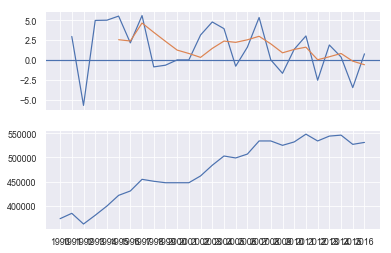

In [8]:
# TEST CELL - CHECK THE ROLLLING AVERAGE CALCULATION IS CORRECT.
# RESULTS - YES, IT'S WORKING.

recent_trends, recent_trends_rolling, unit = utils.calculate_trends(reduced_data, num_years_trend=5)

trends = recent_trends.loc['ZAF']
rolling = recent_trends_rolling.loc['ZAF']
abs_emis = reduced_data.loc['ZAF']

fig, ax = plt.subplots(2,1, sharex=True, sharey=False)
ax[0].plot(trends.T)
ax[0].axhline(0)
ax[0].plot(rolling.T)
#ax[1].axhline(0)
ax[1].plot(abs_emis.T)
plt.show()

In [9]:
# SHOW SUBSETS OF THE PEAKING CRITERIA

peaking_assessment['check'] = ((peaking_assessment['max_reached']==False) & \
                                    (peaking_assessment['strongly_decreasing']))
peaking_assessment['trend'] = recent_trends_rolling[str(end_year)]
peaking_assessment.loc[peaking_assessment['check']]


,max year,max_reached,trend,decreasing,strongly_decreasing,stable,peaked,stabilised,not_peaked,check
country,,,,,,,,,,
BHR,2014,False,-1.661381,True,True,False,False,True,False,True
BWA,2011,False,-3.063609,True,True,False,False,True,False,True
IDN,2012,False,-2.178261,True,True,False,False,True,False,True
LBN,2014,False,-1.976531,True,True,False,False,True,False,True
MKD,2012,False,-1.910929,True,True,False,False,True,False,True
MLT,2012,False,-7.933403,True,True,False,False,True,False,True
